## Data preprocessing

##### Copyright (C) Microsoft Corporation.  
see license file for details

In [41]:
# Allow multiple displays per cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [42]:
# AZUREML_NATIVE_SHARE_DIRECTORY mapping to host dir is set by _nativeSharedDirectory_ in .compute file 

import os
try:
    amlWBSharedDir = os.environ['AZUREML_NATIVE_SHARE_DIRECTORY']    
except:
    amlWBSharedDir = ''
    print('not using aml services?')
    
amlWBSharedDir

'/azureml-share/'

In [43]:
# # Use the Azure Machine Learning data collector to log various metrics
# from azureml.logging import get_azureml_logger
# logger = get_azureml_logger()

In [44]:
# Use Azure Machine Learning history magic to control history collection
# History is off by default, options are "on", "off", or "show"
# %azureml history on

In [45]:
# import utlity functions

import sys, os
paths_to_append = [os.path.join(os.getcwd(), os.path.join(*(['Code',  'src'])))]
def add_path_to_sys_path(path_to_append):
    if not (any(path_to_append in paths for paths in sys.path)):
        sys.path.append(path_to_append)

[add_path_to_sys_path(crt_path) for crt_path in paths_to_append]

import trvis_utils, image_featurization

[None]

In [46]:
#### Path variables

In [47]:
prj_consts = trvis_utils.trvis_consts()
data_base_input_dir=os.path.join(amlWBSharedDir, os.path.join(*(prj_consts.BASE_INPUT_DIR_list)))
data_dir = os.path.join(data_base_input_dir, os.path.join(*(['cats_and_dogs', 'train'])))
output_dir = os.path.join(data_base_input_dir, os.path.join(*(['processed'])))

os.makedirs(output_dir, mode=0o777, exist_ok=True)
output_dir

'/azureml-share/data/processed'

In [48]:
from keras.applications.resnet50 import ResNet50
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import random


from keras.layers import Dense
from keras.models import Model
from keras_contrib.applications.densenet import DenseNetImageNet121
import keras_contrib

In [49]:
RECOMPUTE=False
SAMPLE_DATA = False
    
# densenet layers
# name          size    connected_to
# dense_2_3_bn  1408    concatenate_311
# dense_2_8_bn  2048    concatenate_316 
# dense_2_10_bn 2304    concatenate_318  
              
# model_name_list = [ResNet50, DenseNetImageNet121, DenseNetImageNet121, DenseNetImageNet121, DenseNetImageNet121]
# model_layer_list = ['','dense_2_3_bn', 'dense_2_8_bn', 'dense_2_10_bn', '']    
model_name_list = [ResNet50]
model_layer_list = ['']

sample_size = 1000
saved_data_file_appendix = ''
if SAMPLE_DATA:
    saved_data_file_appendix = '_sample'


In [50]:
%matplotlib inline

import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt

In [51]:
training_image_files = os.listdir(data_dir)

if SAMPLE_DATA:
    training_image_files= random.sample(training_image_files, sample_size)

len(training_image_files)
training_image_files[:2]
image_file_names = list(os.path.join(data_dir, fname) for fname in training_image_files)
image_file_names[:2]

25000

['dog.6858.jpg', 'dog.1106.jpg']

['/azureml-share/data/cats_and_dogs/train/dog.6858.jpg',
 '/azureml-share/data/cats_and_dogs/train/dog.1106.jpg']

In [52]:
os.listdir(output_dir)

['labels_.npy',
 'features_ResNet50tsne.npy',
 'labels__sample.npy',
 'features_ResNet50.npy',
 'features_ResNet50_sample.npy',
 'features_ResNet50_sampletsne.npy']

In [53]:
# somemodel = DenseNetImageNet121(input_shape=(224, 224, 3),
#                                      weights='imagenet',
#                                      include_top=False,
#                                      pooling=None)
# model_summary = somemodel.summary()
# model_summary

In [54]:
class pretrained_model:
    def __init__(self, DL_architecture, intermediate_layer = ''):
        self.name = DL_architecture.__name__
        pooling_value = 'avg'
        if DL_architecture.__name__=='DenseNetImageNet121':
            pooling_value = 'None'
        crt_model = DL_architecture(input_shape=(224, 224, 3),
                                     weights='imagenet',
                                     include_top=False,
                                     pooling=pooling_value)
        if not (intermediate_layer==''):
             crt_model = Model(inputs=crt_model.input, outputs=crt_model.get_layer(intermediate_layer).output)
        self.model = crt_model

def pretrained_models_generator(model_name_list):
    """Yield successive pretrained models."""
    for crt_model_name in model_name_list: 
        yield pretrained_model(crt_model_name)
   
# crt_pretrained_models = [pretrained_model(ResNet50), pretrained_model(DenseNetImageNet121)]
# print(crt_model.name for crt_model in crt_pretrained_models)
# models = dict([ (m.name, m.model) for m in crt_pretrained_models ])

In [55]:
def featurize_images_multiple_models(crt_image_file_names, output_dir, model_name_list, batch_size=64):
    for crt_model_name, crt_model_layer in zip(model_name_list, model_layer_list):
        print('processing model ' + crt_model_name.__name__+' layer '+crt_model_layer)
        features_filename = os.path.join(output_dir, 'features_' +\
                                         crt_model_name.__name__+saved_data_file_appendix+\
                                         crt_model_layer+'.npy')
        if os.path.isfile(features_filename) and RECOMPUTE is False:
            print("Features found!")
        else:
            print("Computing features")
            crt_model = pretrained_model(crt_model_name, crt_model_layer).model
            features = image_featurization.featurize_images(crt_image_file_names, crt_model, batch_size) 
            print(features.shape)
            np.save(features_filename, features)
            del crt_model

featurize_images_multiple_models(image_file_names, output_dir, model_name_list)            

processing model ResNet50 layer 
Features found!


In [56]:
# model_name_list = [DenseNetImageNet121]

In [57]:
def apply_tsne_to_multiple_features(output_dir, crt_model_name_list):
    for crt_model_name, crt_model_layer in zip(model_name_list, model_layer_list):
        print('tsne processing for model ' + crt_model_name.__name__)
        tsne_features_filename = os.path.join(output_dir, 'features_' + \
                                              crt_model_name.__name__+saved_data_file_appendix+\
                                              crt_model_layer+'tsne.npy')
        if os.path.isfile(tsne_features_filename) and RECOMPUTE is False:
            print("tsne features found!")
        else:
            print("Computing tsne features")
            original_features = np.load(os.path.join(output_dir, 'features_' + \
                                                     crt_model_name.__name__+saved_data_file_appendix+\
                                                     crt_model_layer+'.npy'))
            print(original_features.shape)
            original_features = original_features.reshape(original_features.shape[0], -1)
            print(original_features.shape)
            images_tsne = TSNE(n_components=2, random_state=0).fit_transform(original_features)
            print(images_tsne.shape)
            np.save(tsne_features_filename, images_tsne)
apply_tsne_to_multiple_features(output_dir, model_name_list)                        

tsne processing for model ResNet50
tsne features found!


In [58]:
labels_filename = os.path.join(output_dir, 'labels_' + \
                                              saved_data_file_appendix+\
                                              '.npy')
if os.path.isfile(labels_filename) and RECOMPUTE is False:
    print('Label file '+labels_filename+' found!')
    y = np.load(labels_filename)
else:
  y = pd.Series(training_image_files).str.contains('cat').astype(int).values
  np.save(labels_filename, y)

print(y.shape)
print(y[y==0].shape)
print(y[y==1].shape)


Label file /azureml-share/data/processed/labels_.npy found!
(25000,)
(12500,)
(12500,)


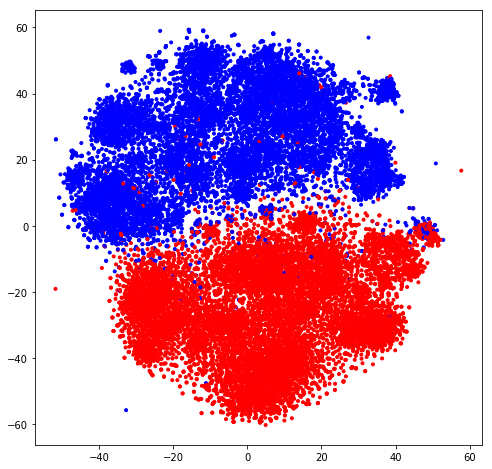

In [59]:
cat_labels = y == 0
dog_labels = y == 1
def visualize_tsne_features(crt_model_name_list):
    for crt_model_name, crt_model_layer in zip(model_name_list, model_layer_list):
        tsne_features_filename = os.path.join(output_dir, 'features_' + \
                                              crt_model_name.__name__+saved_data_file_appendix+\
                                              crt_model_layer+'tsne.npy')
        tsne_features = np.load(tsne_features_filename)
        plt.figure(figsize=(8, 8))
        plt.scatter(x = tsne_features[:,0], y=tsne_features[:,1], marker=".", c=y, cmap=plt.cm.get_cmap('bwr'))

        plt.show()
        
visualize_tsne_features(model_name_list)      

In [60]:
# jupyter nbconvert --to html .\Code\02_Model\010_visualize_tl_features.ipynb